In [63]:
from sentence_transformers import SentenceTransformer, models
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import pickle

In [64]:
df_rus = pd.read_csv('data/russian.csv', sep=';')
df_nord = pd.read_csv('data/nordic.csv', sep=';')
df_match = pd.read_csv('data/match.csv', sep=';')

df_rus = df_rus.drop_duplicates('word')
df_nord = df_nord.drop_duplicates('word')

match_nr = {}
match_rn = {}
for i in df_match.index :
    match_nr[df_match['nord'][i]] = df_match['rus'][i]
    match_rn[df_match['rus'][i]] = df_match['nord'][i]
with open('data/trained_5.pkl', 'rb') as f :
    trained = pickle.load(f)
with open('data/untrained.pkl', 'rb') as f :
    untrained = pickle.load(f)



In [65]:
def assign_scores(embeddings) :
    count = 0
    length = len(df_nord)
    true = 0

    y_true = []
    y_score = []


    for word1 in df_nord['word'] :
        print('{:3.2f}'.format(count / length * 100) + '%', end = '\r')
        emb1 = embeddings[word1]
        for word2 in df_rus['word'] :
            emb2 = embeddings[word2]
            sim = 1 - np.abs(cosine(emb1, emb2))
            y_true.append(1 if (word1, word2) in match_nr.items() else 0)
            y_score.append(sim)
        count += 1
    return (y_true, y_score)

print('Scoring untrained...')
(y_true_u, y_score_u) = assign_scores(untrained)
print('Scoring trained...')
(y_true_t, y_score_t) = assign_scores(trained)

Scoring untrained...
Scoring trained...


In [66]:
(fpr_u, tpr_u, threshold_u) = sklearn.metrics.roc_curve(y_true_u, y_score_u)
(fpr_t, tpr_t, threshold_t) = sklearn.metrics.roc_curve(y_true_t, y_score_t)

sum_true = sum(y_true_t)
print(sum_true)
print(len(match_nr))

cutoff_u = 0
cutoff_t = 0
max_ba_u = 0
max_ba_t = 0
for i in range(len(fpr_u)) :
    temp = (tpr_u[i] + 1 - fpr_u[i]) / 2
    if temp > max_ba_u :
        max_ba_u = temp
        cutoff_u = i
    temp = (tpr_t[i] + 1 - fpr_t[i]) / 2
    if temp > max_ba_t :
        max_ba_t = temp
        cutoff_t = i

#cutoff_u = threshold_u[cutoff_u]
#cutoff_t = threshold_t[cutoff_t]



76
95


avgrec:
0.9584449722423622
0.954693670054687

optimal tpr:
0.9473684210526315
0.9473684210526315

true predicted
72.0
72.0

false predicted:
2.3163642191609175
2.8865621516875626

0.9923771158033535
0.9848026263069325


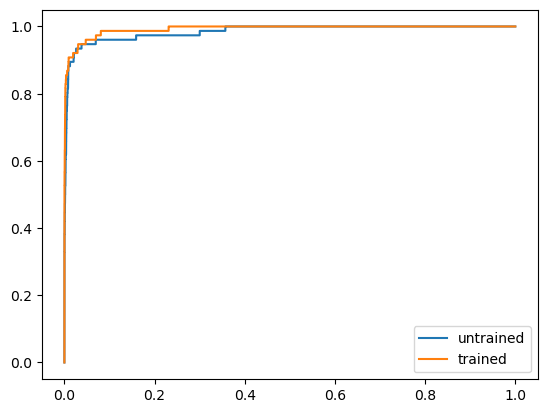

In [67]:
plt.step(fpr_u, tpr_u, label='untrained')
plt.step(fpr_t, tpr_t, label='trained')
plt.legend()

print('avgrec:')
print(max_ba_t)
print(max_ba_u)

print()

print('optimal tpr:')
print(tpr_t[cutoff_t])
print(tpr_u[cutoff_u])

print()

print('true predicted')
print(tpr_t[cutoff_t] * sum_true)
print(tpr_u[cutoff_u] * sum_true)

print()

print('false predicted:')
print(fpr_t[cutoff_t] * sum_true)
print(fpr_u[cutoff_u] * sum_true)


print()


print(sklearn.metrics.auc(fpr_t, tpr_t))
print(sklearn.metrics.auc(fpr_u, tpr_u))


[[1056443   41709]
 [      5      71]]
[[1064682   33470]
 [      5      71]]


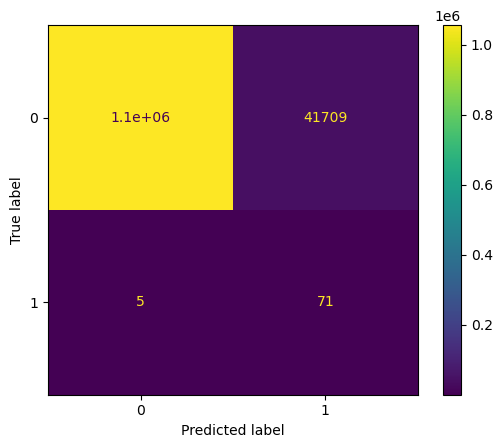

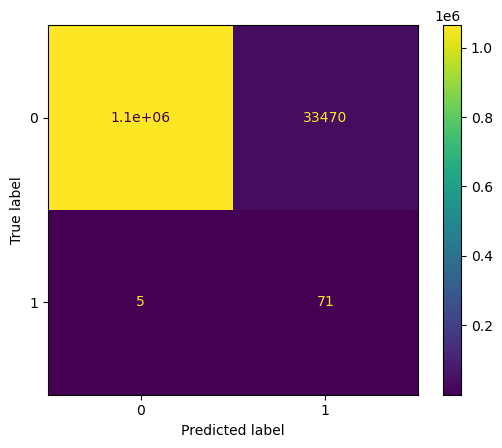

In [68]:
def classify(y_score, threshold) :
    y_pred = []
    for y in y_score :
        y_pred.append(1 if y > threshold else 0)
    return y_pred


y_pred_u = classify(y_score_u, threshold_u[cutoff_u])
y_pred_t = classify(y_score_t, threshold_t[cutoff_t])

conf_u = sklearn.metrics.confusion_matrix(y_true_u, y_pred_u)
conf_t = sklearn.metrics.confusion_matrix(y_true_t, y_pred_t)

disp1 = sklearn.metrics.ConfusionMatrixDisplay(conf_u)
disp2 = sklearn.metrics.ConfusionMatrixDisplay(conf_t)

print(conf_u)
print(conf_t)

disp1.plot()
disp2.plot()

average precision for untrained 0.11372050847866859
average precision for trained 0.22207031322609785


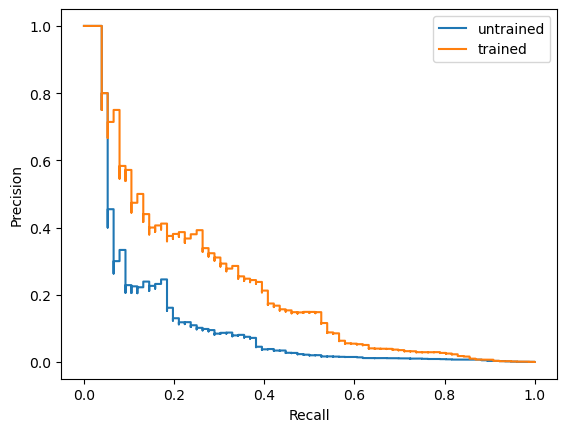

In [69]:
(prec_u, recall_u, prc_thres_u) = sklearn.metrics.precision_recall_curve(y_true_u, y_score_u)
(prec_t, recall_t, prc_thres_t) = sklearn.metrics.precision_recall_curve(y_true_t, y_score_t)

fig, ax = plt.subplots()

disp1 = sklearn.metrics.PrecisionRecallDisplay(prec_u, recall_u)
disp2 = sklearn.metrics.PrecisionRecallDisplay(prec_t, recall_t)
disp1.plot(ax=ax, name='untrained')
disp2.plot(ax=ax, name='trained')
plt.legend()

print('average precision for untrained', sklearn.metrics.average_precision_score(y_true_u, y_score_u))
print('average precision for trained', sklearn.metrics.average_precision_score(y_true_t, y_score_t))

[[1097358     794]
 [     46      30]]
[[1098037     115]
 [     46      30]]


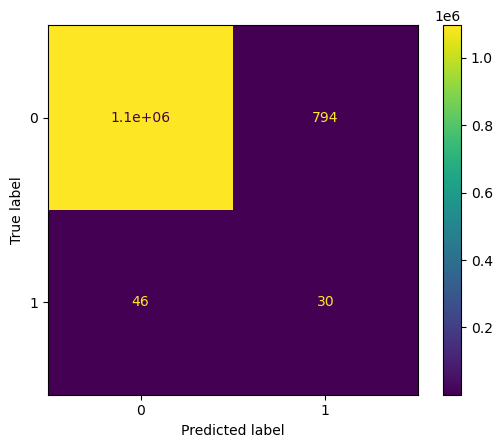

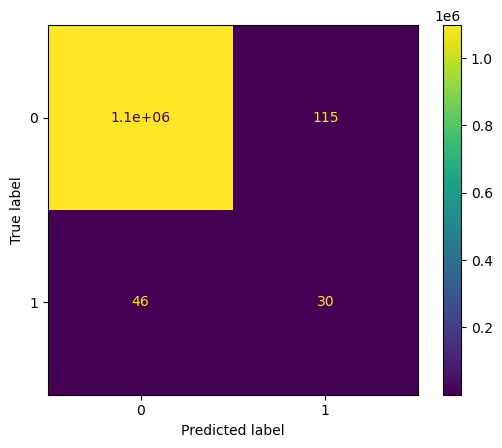

In [70]:
rec_cutoff_u = 0
rec_cutoff_t = 0

for i in reversed(range(len(recall_u))) :
    if recall_u[i] > 0.4 :
        rec_cutoff_u = i
        break

for i in reversed(range(len(recall_t))) :
    if recall_t[i] > 0.4 :
        rec_cutoff_t = i
        break


y_pred_u = classify(y_score_u, prc_thres_u[rec_cutoff_u])
y_pred_t = classify(y_score_t, prc_thres_t[rec_cutoff_t])

conf_u = sklearn.metrics.confusion_matrix(y_true_u, y_pred_u)
conf_t = sklearn.metrics.confusion_matrix(y_true_t, y_pred_t)

disp1 = sklearn.metrics.ConfusionMatrixDisplay(conf_u)
disp2 = sklearn.metrics.ConfusionMatrixDisplay(conf_t)

print(conf_u)
print(conf_t)

disp1.plot()
disp2.plot()

In [71]:
with open('data/score_contrastive_45_1800.pkl', 'wb') as f:
    pickle.dump(y_score_t, f)
with open('data/y_true.pkl', 'wb') as f:
    pickle.dump(y_true_t, f)


In [72]:
print(df_rus)

      Unnamed: 0                                               word
0              0  наличие сельскохозяйственной техники (окончате...
1              1      общая земельная площадь (окончательные итоги)
2              2  площади многолетних плодовых насаждений и ягод...
3              3  посевная площадь по видам сельскохозяйственных...
4              4  средний размер хозяйств по общей площади и сел...
...          ...                                                ...
5241        5241  число лиц, которым рекомендованы индивидуальны...
5242        5242  число лиц, обратившихся в медицинские организа...
5243        5243  доля аспирантов и соискателей, защитивших канд...
5244        5244  доля трудоустроенных выпускников образовательн...
5245        5245  число активных "личных кабинетов" информационн...

[5156 rows x 2 columns]


In [74]:


df_results = pd.DataFrame(columns=['nord', 'rus', 'true'])


count = 0
for i in range(len(df_nord)) :
    for j in range(len(df_rus)) :
        if y_pred_t[count] == 1 :
            df_results.loc[count, 'nord'] = df_nord['word'][i]
            df_results.loc[count, 'rus'] = df_rus['word'][j]
            df_results.loc[count, 'true'] = y_true_t[count]
        count += 1

df_results = df_results.reset_index(drop=True)
df_results.to_csv('results.csv', sep=';')



KeyError: 38